In [20]:
import pandas as pd
import json
import os
from datetime import datetime, timedelta
import shutil
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from IPython.display import Markdown, display
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
from IPython.display import display, Markdown
from IPython.display import Javascript

confidence_threshold = 0.8
#display options
N_occurence_threshold_annual = 10
N_occurence_threshold_daily = 20
date_tick = 5
cluster_name = "Cap Lardier" #Cap Lardier , Porquerolles, Port-Cros, Vieux Salins ,  Salins des Pesquiers

database_path = f"merged_predictions_light/country=France"

multilingual_key = pd.read_csv('TABMON_MULTILINGUAL_KEY.csv') 
multilingual_key_dict = multilingual_key.set_index('Scientific_Name')['French_ioc'].to_dict()
#multilingual_key_dict = multilingual_key.set_index('Scientific_Name')['English_ioc'].to_dict()

site_info = pd.read_csv('site_info.csv') 

plot_width = 12
plt.rcParams.update({'font.size': 8})
plt.rcParams["figure.dpi"] = 150 

display(Markdown(f"<h1> Rapport TABMON :  {cluster_name} "))



<h1> Rapport TABMON :  Cap Lardier 

In [21]:


deploymentID_list = site_info[site_info["Cluster"]==cluster_name]["DeploymentID"].tolist()
bugg_id_list = site_info[site_info["Cluster"]==cluster_name]["DeviceID"].tolist()
site_list = site_info[site_info["Cluster"]==cluster_name]["Site"].tolist()
deployment_date_list = site_info[site_info["Cluster"]==cluster_name]["deploymentBeginDate"]

indexes = [bugg_id_list.index(x) for x in set(bugg_id_list)]
bugg_id_list =  [bugg_id_list[id] for id in indexes]
site_list =  [site_list[id] for id in indexes]
#print(deploymentID_list)
#print(bugg_id_list)
#print(site_list)
#print(deployment_date_list)
deployment_date_list = [ datetime.strptime(f"{date}", "%d/%m/%Y") for date in deployment_date_list]


In [22]:
species_filter = ["Porzana porzana","Tetrao urogallus"]


file_path_list = []
for bugg_id in bugg_id_list:
    bugg_path = os.path.join(database_path, f"device_id={bugg_id}")
    bugg_files = sorted(os.listdir(bugg_path))

    file_path_list.append([os.path.join(bugg_path, file) for file in bugg_files])



def parse_date(date_str):
    formats = [
        "%Y-%m-%dT%H:%M:%S.%fZ",
        "%Y-%m-%dT%H:%M:%SZ",
        "%Y-%m-%dT%H:%MZ"
    ]
    for fmt in formats:
        try:
            return datetime.strptime(date_str, fmt)
        except ValueError:
            continue
    raise ValueError(f"Date format not supported: {date_str}")


def get_file_date(bugg_file_name):
    date = bugg_file_name.replace('.mp3', '')
    date = date.replace('_', ':')
    date = parse_date(date)
    return date.date()


def get_file_time(bugg_file_name):
    date = bugg_file_name.replace('.mp3', '')
    date = date.replace('_', ':')
    date = parse_date(date)
    return date.hour

def get_bugg_id(folder_name):
    part = folder_name.split('-', 1)[1]
    part = part[1:]
    part = part.lstrip('0')
    return part


def load_parquet(file_path):  
    predictions_df = pd.read_parquet(file_path, engine='pyarrow') 
    #predictions_df = predictions_df.drop('energy', axis=1)
    #predictions_df = predictions_df.drop('model', axis=1)
    #predictions_df = predictions_df.drop('model_checkpoint', axis=1)
    #predictions_df = predictions_df.drop('datetime', axis=1)
    #predictions_df = predictions_df.drop('lat', axis=1)
    #predictions_df= predictions_df.drop('lng', axis=1)

    predictions_df = predictions_df[predictions_df["confidence"] > confidence_threshold]

    for species in species_filter:
        predictions_df = predictions_df[predictions_df["scientific name"] != species]

    predictions_df['date'] = predictions_df['filename'].apply(get_file_date)
    predictions_df['time'] = predictions_df['filename'].apply(get_file_time)


    return predictions_df



# Activité des enregistreurs
Les microphones enregistrent l'activité acoustique 24h/24 par ficher de 5 min et les envoient par 4G.
La figure suivante présente le nombre d'enregistrements reçus par jour pour chaque enregistreur de la zone.
En fonctionnement normal, nous devons recevoir 288 fichiers par enregistreurs par jour (ligne verte).
Le manque d'enregistrement est le plus souvent dû à une mauvaise connexion sur la zone, mais peut aussi venir de problèmes d'alimentation (panneau solaire ou batterie) ou de dysfonctionnements internes du microphone.


In [23]:
index_path = "index.parquet"
index_df = pd.read_parquet(index_path, engine='pyarrow')
index_df = index_df[index_df["MimeType"]=='audio/mpeg']
index_df = index_df[list(map(lambda x: x.startswith('bugg_RPiID'), index_df['device']))]
index_df["date"] = index_df.apply(lambda row: get_file_date(row['Name']), axis=1)
index_df = index_df[["date", "Name", "device"]]
index_df["bugg_id"] = index_df.apply(lambda row: get_bugg_id(row['device']), axis=1)

#print(index_df["bugg_id"].unique())

index_df = index_df[index_df["bugg_id"].isin(bugg_id_list)]

#print(index_df["bugg_id"].unique())



full_date_range = pd.date_range(
    #start=index_df['date'].min(),
    #start="2025-05-01",
    start = min(deployment_date_list),
    end=index_df['date'].max(),
    freq='D'  # daily
).date 


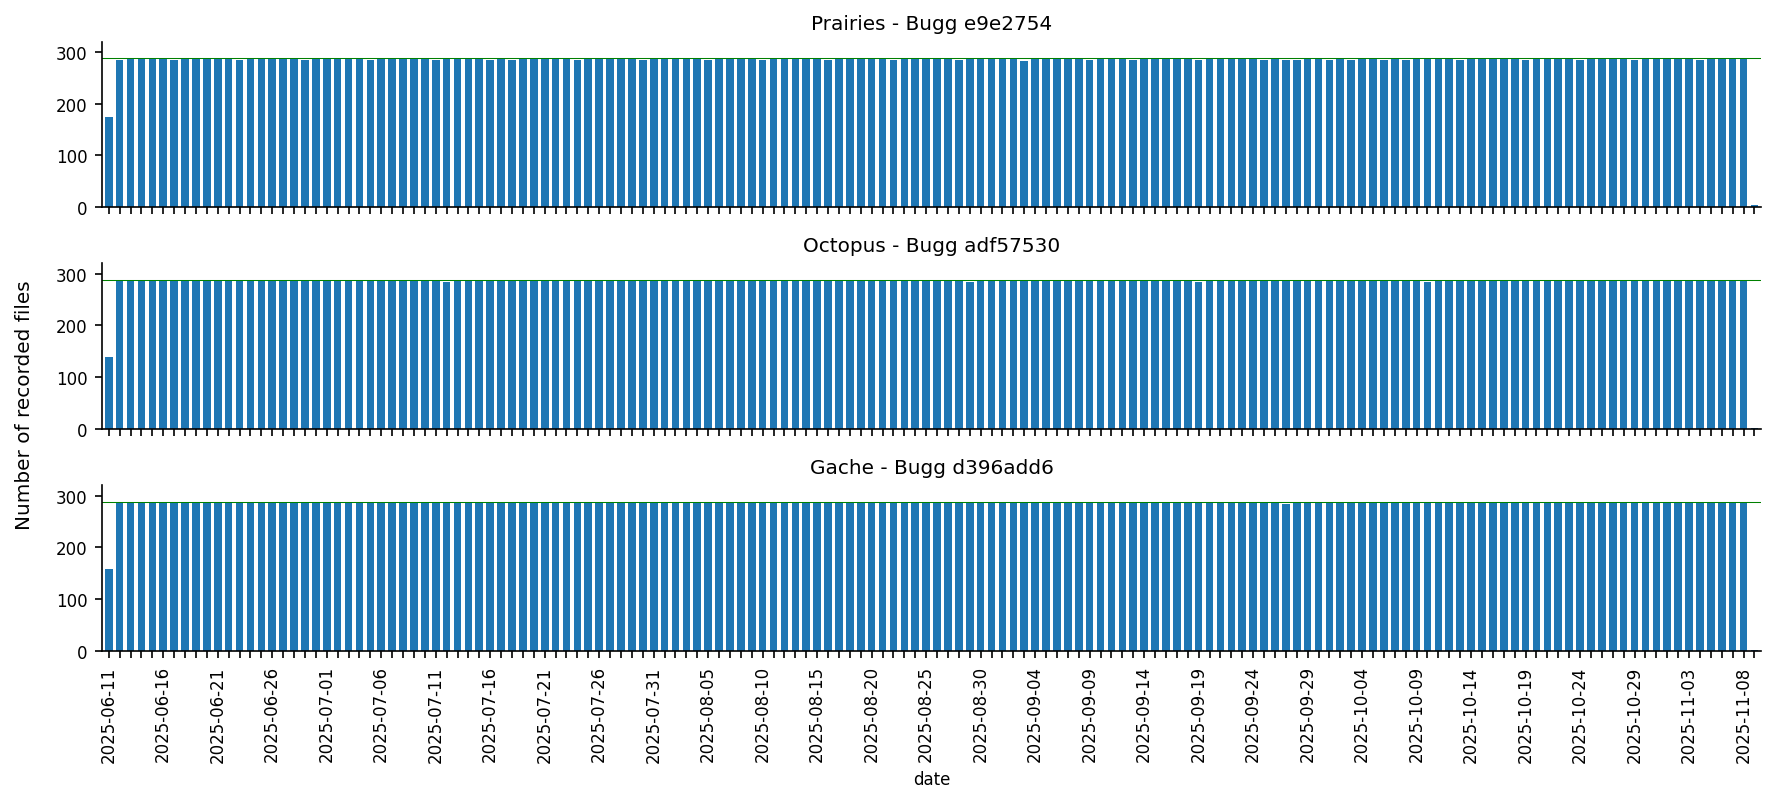

In [24]:


N_plot = len(bugg_id_list)
fig, ax = plt.subplots(N_plot,1, figsize=(plot_width , 1.8*N_plot), sharex=True )

fig.supylabel("Number of recorded files \n")


for i, bugg_id in enumerate(bugg_id_list):

    ax[i].set_title( f"{site_list[i]} - Bugg {bugg_id}")
    date_counts = index_df['date'][index_df["device"].str.endswith(bugg_id)].value_counts().sort_index()
    date_counts = date_counts.reindex(full_date_range, fill_value=0)

    date_counts.plot(kind='bar', ax=ax[i],width = 0.7 )

    #ax[i].set_ylabel("Number of files")

    ax[i].axhline(y=288, color='g', linewidth=0.5)
    ax[i].set_ylim([0,320])
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    xticks = ax[i].xaxis.get_major_ticks()

    for j,tick in enumerate(xticks):
        if j%date_tick != 0:
            tick.label1.set_visible(False)


plt.tight_layout()


In [25]:

predictions_df = [ load_parquet(file_path) for file_path in file_path_list]
predictions_df = pd.concat(predictions_df, ignore_index=True)
N_tot = predictions_df.shape[0]
predictions_df['common name'] = predictions_df['scientific name'].map(multilingual_key_dict)

#print(predictions_df.columns)

analyzed_date_range = pd.date_range(
    #start=index_df['date'].min(),
    #start="2025-05-01",
    start = min(deployment_date_list),
    end=predictions_df['date'].max(),
    freq='D'  # daily
).date 


# Espèces détectées


In [26]:
display(Markdown(f"Nous utilisons pour l'instant BirdNET pour détecter les espèces d'oiseaux présentes sur les enregistrements. Les enregistrements sont divisés en segments de 3 secondes avant d'être analysés. Pour chaque segment, BirdNET fournit un score de confiance compris entre 0 et 1 à chaque espèce. La figure suivante présente le nombre de détections par espèce dont le score de confiance est supérieur à {confidence_threshold}."))


Nous utilisons pour l'instant BirdNET pour détecter les espèces d'oiseaux présentes sur les enregistrements. Les enregistrements sont divisés en segments de 3 secondes avant d'être analysés. Pour chaque segment, BirdNET fournit un score de confiance compris entre 0 et 1 à chaque espèce. La figure suivante présente le nombre de détections par espèce dont le score de confiance est supérieur à 0.8.


Le nombre de détections correspond au nombre de segments de 3 secondes dans lequel l'espèce est détectée.
Le graphique suivant présente le nombre de détections par espèce sur la zone sur toute la période. 
Il est à noter que dans l'ensemble du document le nombre de détections est affiché selon une échelle avec une graduation logarithmique.
Ces données doivent être considérées avec prudence, en particulier pour les espèces qui n'ont été détectées qu'à quelques reprises. Il s'agit des résultats bruts fournis par BirdNET, qui n'ont pas été vérifiés manuellement. De plus, les performances de BirdNET peuvent varier fortement d'une espèce à l'autre. 

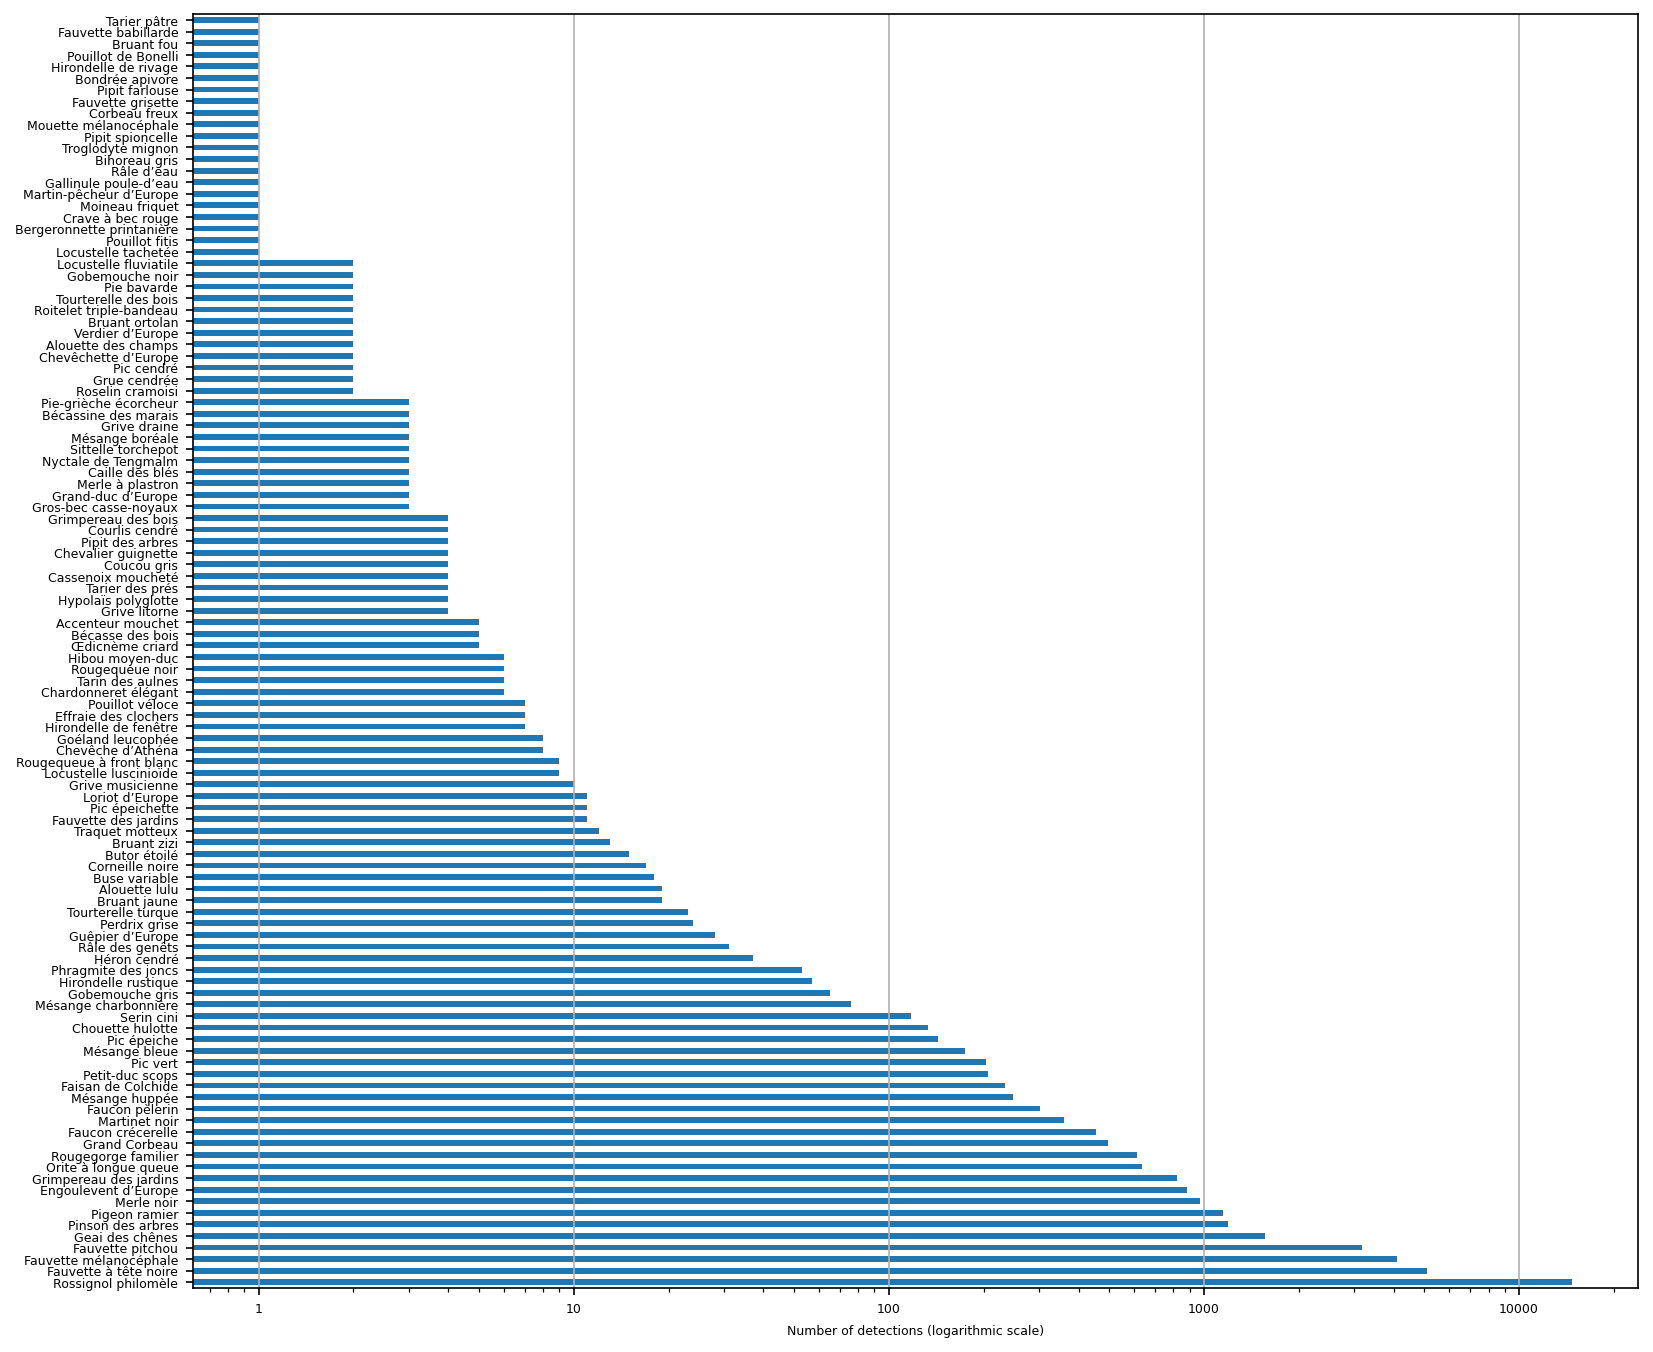

In [27]:
n_species = predictions_df['common name'].value_counts().shape[0]

plt.rcParams.update({'font.size': 6})

# Create figure and axis
fig, ax = plt.subplots(figsize=(plot_width-1 , int(n_species/12)))

# Plot using the specific axis
predictions_df['common name'].value_counts().plot(kind='barh', ax=ax)

# Set x-axis to logarithmic scale
ax.set_xscale('log')

# Disable scientific notation on x-axis
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)
# Optional: add labels and title
ax.set_xlabel("Number of detections (logarithmic scale)")
ax.set_ylabel("")

#ax.set_title(f"Number of detections per species - {cluster_name}")
ax.xaxis.grid()# Show plot
plt.tight_layout()


---
\newpage
---

# Evolution journalière


In [28]:
display(Markdown(f"La figure suivante montre l'activité journalière de chaque espèce, en indiquant le nombre de détections par tranche horaire. Seule les espèces avec plus de {N_occurence_threshold_daily} détections au total sont affichées. Il est à noter que l'heure indiquée est l'heure UTC, qui a deux heures de retard sur notre heure d'été et une heure de retard sur notre heure d'hiver (ex. : 12h UTC = 14h en été)."))


La figure suivante montre l'activité journalière de chaque espèce, en indiquant le nombre de détections par tranche horaire. Seule les espèces avec plus de 20 détections au total sont affichées. Il est à noter que l'heure indiquée est l'heure UTC, qui a deux heures de retard sur notre heure d'été et une heure de retard sur notre heure d'hiver (ex. : 12h UTC = 14h en été).

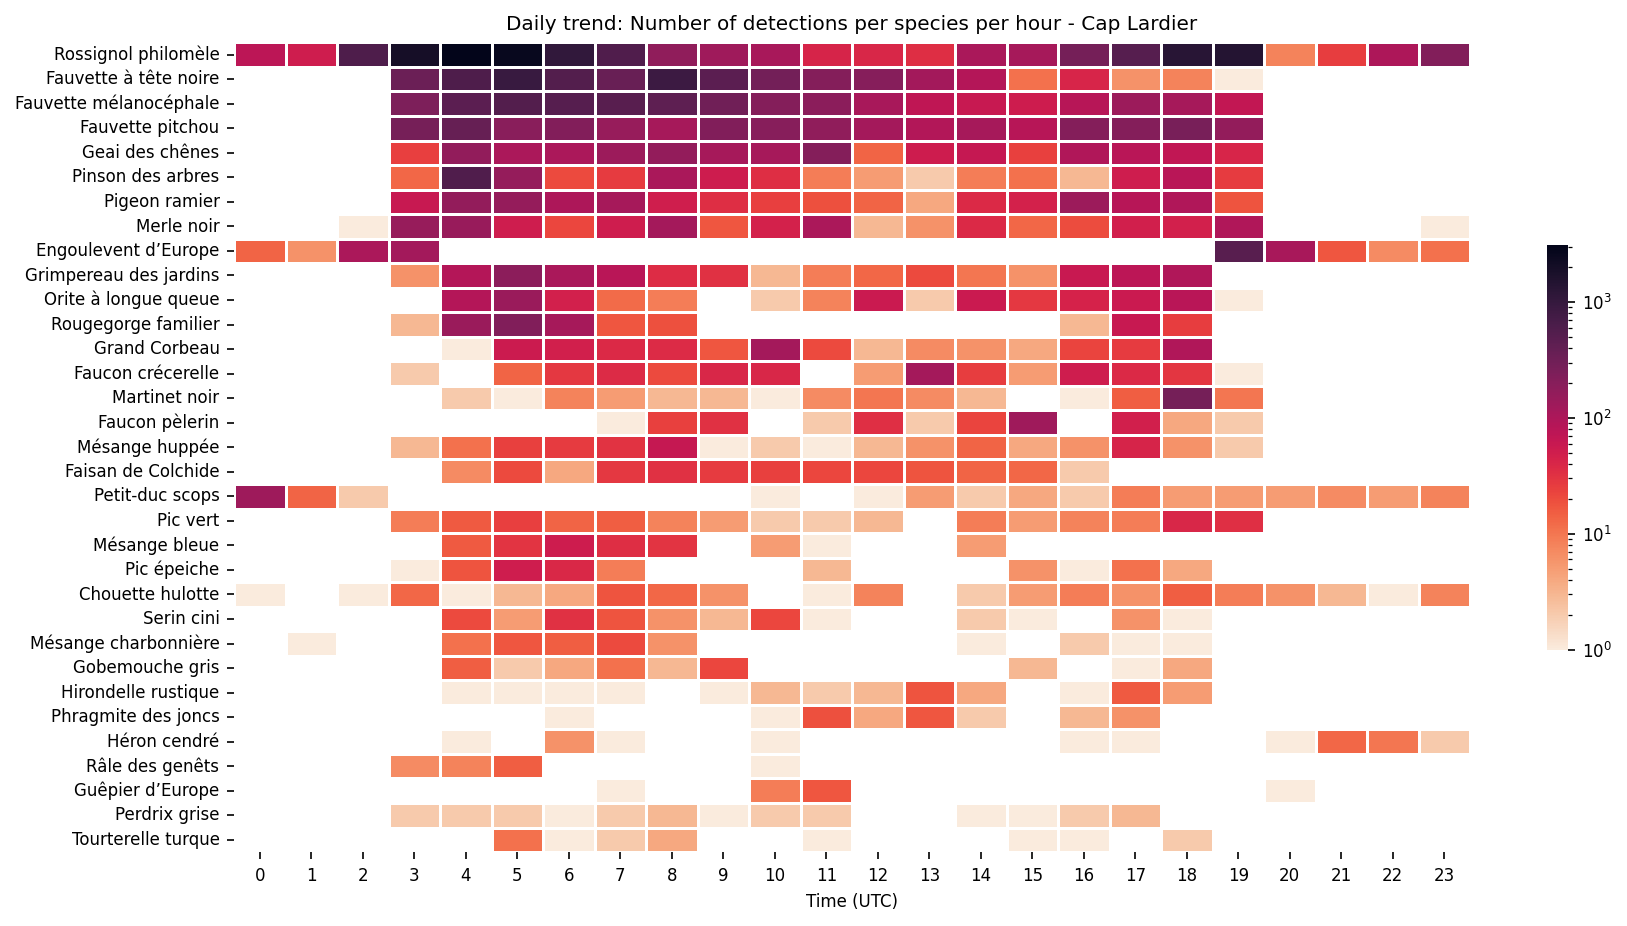

In [29]:
grouped_df = predictions_df.groupby(['time', 'common name']).size().unstack(fill_value=0)
grouped_df = grouped_df.sort_index() # Sort by date 

grouped_df = grouped_df.loc[:,grouped_df.sum()>N_occurence_threshold_daily] #keep species with more than 10 occurence

species_order = grouped_df.sum().sort_values(ascending=False).index.tolist()
grouped_df = grouped_df[species_order]

n_species = grouped_df.shape[1]

plt.rcParams.update({'font.size': 8})

fig, ax = plt.subplots(figsize=(plot_width, 1.5 + n_species/7))

cmap = sns.cm.rocket_r

sns.heatmap(grouped_df.T, norm=LogNorm(), cmap = cmap, cbar_kws={"shrink": 0.5}, linewidth=.5)
ax.set_title(f"Daily trend: Number of detections per species per hour - {cluster_name}")
ax.set_ylabel("")
ax.set_xlabel("Time (UTC)")

plt.tight_layout()



---
\newpage
---

# Evolution annuelle


In [30]:
display(Markdown(f"La figure suivante montre l'evolution des détections jour après jour. Seule les espèces avec plus de {N_occurence_threshold_annual} détections au total sont affichées."))


La figure suivante montre l'evolution des détections jour après jour. Seule les espèces avec plus de 10 détections au total sont affichées.

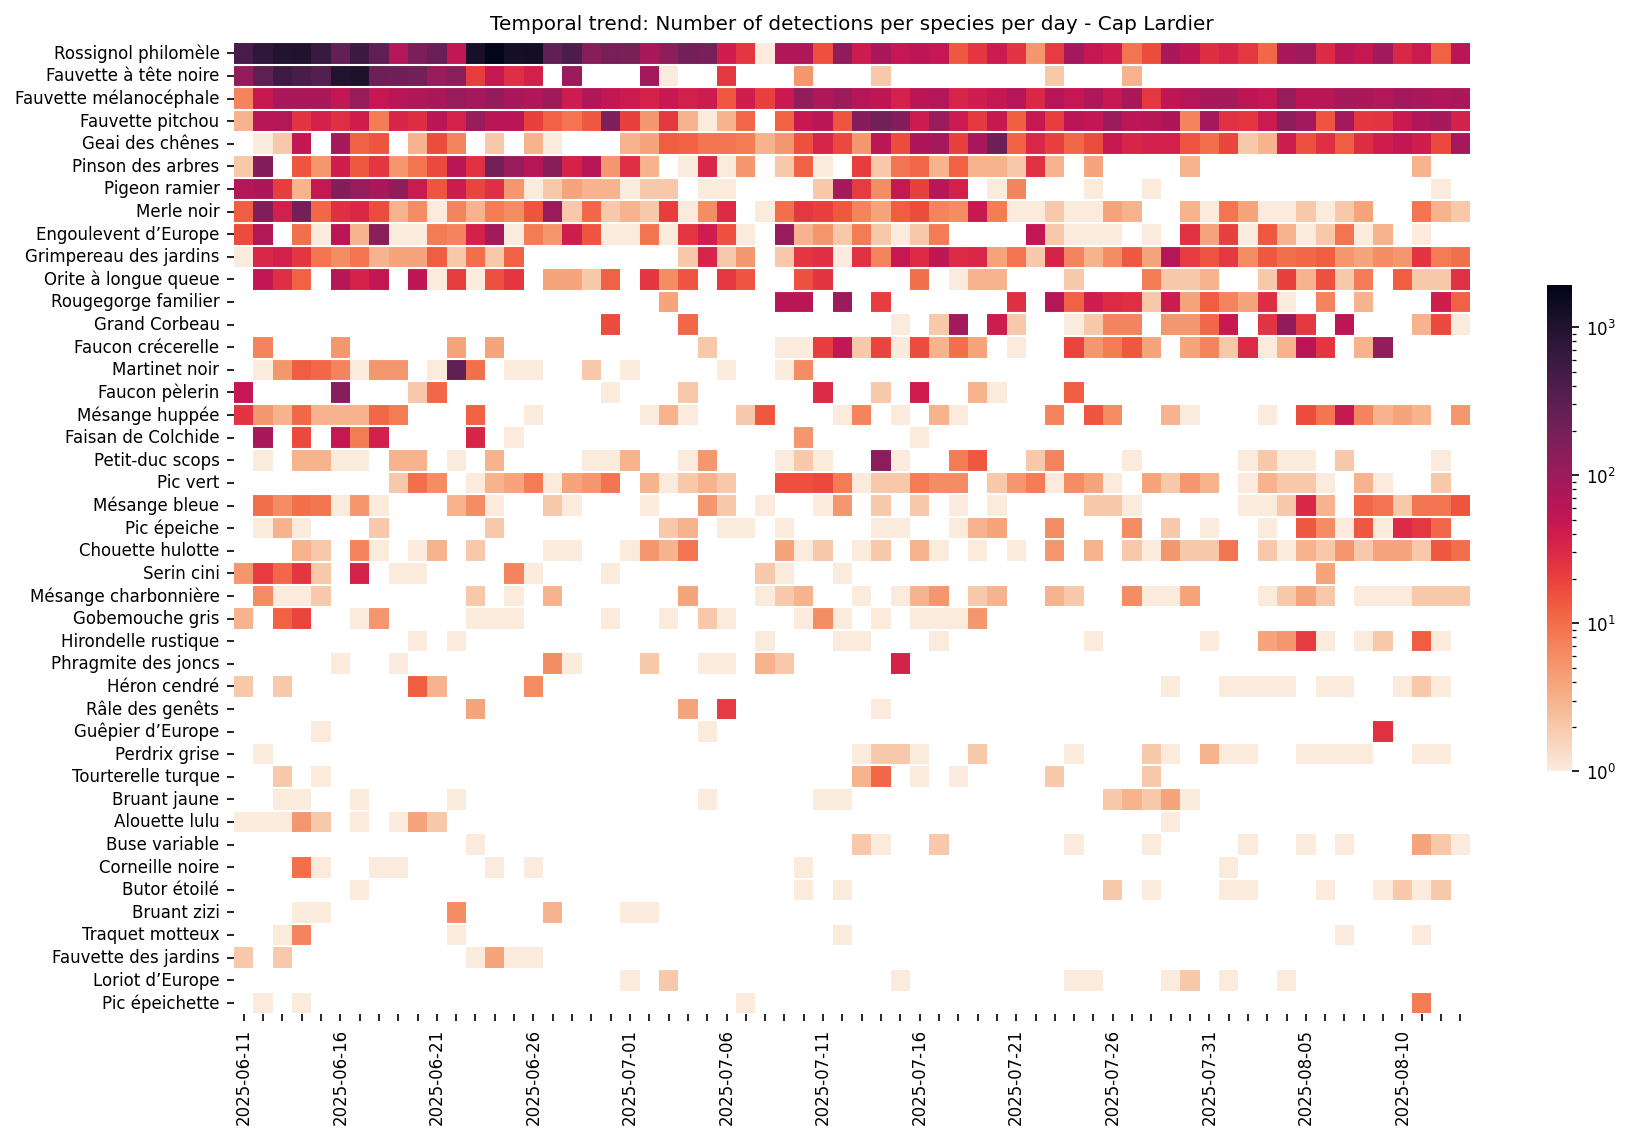

In [31]:




grouped_df = predictions_df.groupby(['date', 'common name']).size().unstack(fill_value=0)
grouped_df = grouped_df.sort_index() # Sort by date 
species_occurence_filter = grouped_df.sum()>N_occurence_threshold_annual
grouped_df = grouped_df.loc[:,species_occurence_filter] #keep species with more than 10 occurence

species_order = grouped_df.sum().sort_values(ascending=False).index.tolist()
grouped_df = grouped_df[species_order]
grouped_df = grouped_df.reindex(analyzed_date_range, fill_value=0)

#grouped_df.reindex(full_date_range, fill_value=0)

n_species = grouped_df.shape[1]

fig, ax = plt.subplots(figsize=(plot_width, 1.5 + n_species/7))

cmap = sns.cm.rocket_r

sns.heatmap(grouped_df.T, norm=LogNorm(), cmap = cmap, cbar_kws={"shrink": 0.5}, linewidth=0)

for i in range(grouped_df.shape[1]+1):
    ax.axhline(i, color='white', lw=1)

#sns.heatmap(grouped_df.T, cmap = cmap, cbar_kws={"shrink": 0.5})
ax.set_title(f"Temporal trend: Number of detections per species per day - {cluster_name}")
ax.set_ylabel("")
ax.set_xlabel("")

xticks = ax.xaxis.get_major_ticks()
for j,tick in enumerate(xticks):
    if j%date_tick != 0:
        tick.label1.set_visible(False)
        
plt.tight_layout()

---
\newpage
---

# Détail par enregistreur

Ces mêmes données sont ici détaillées par enregistreur.

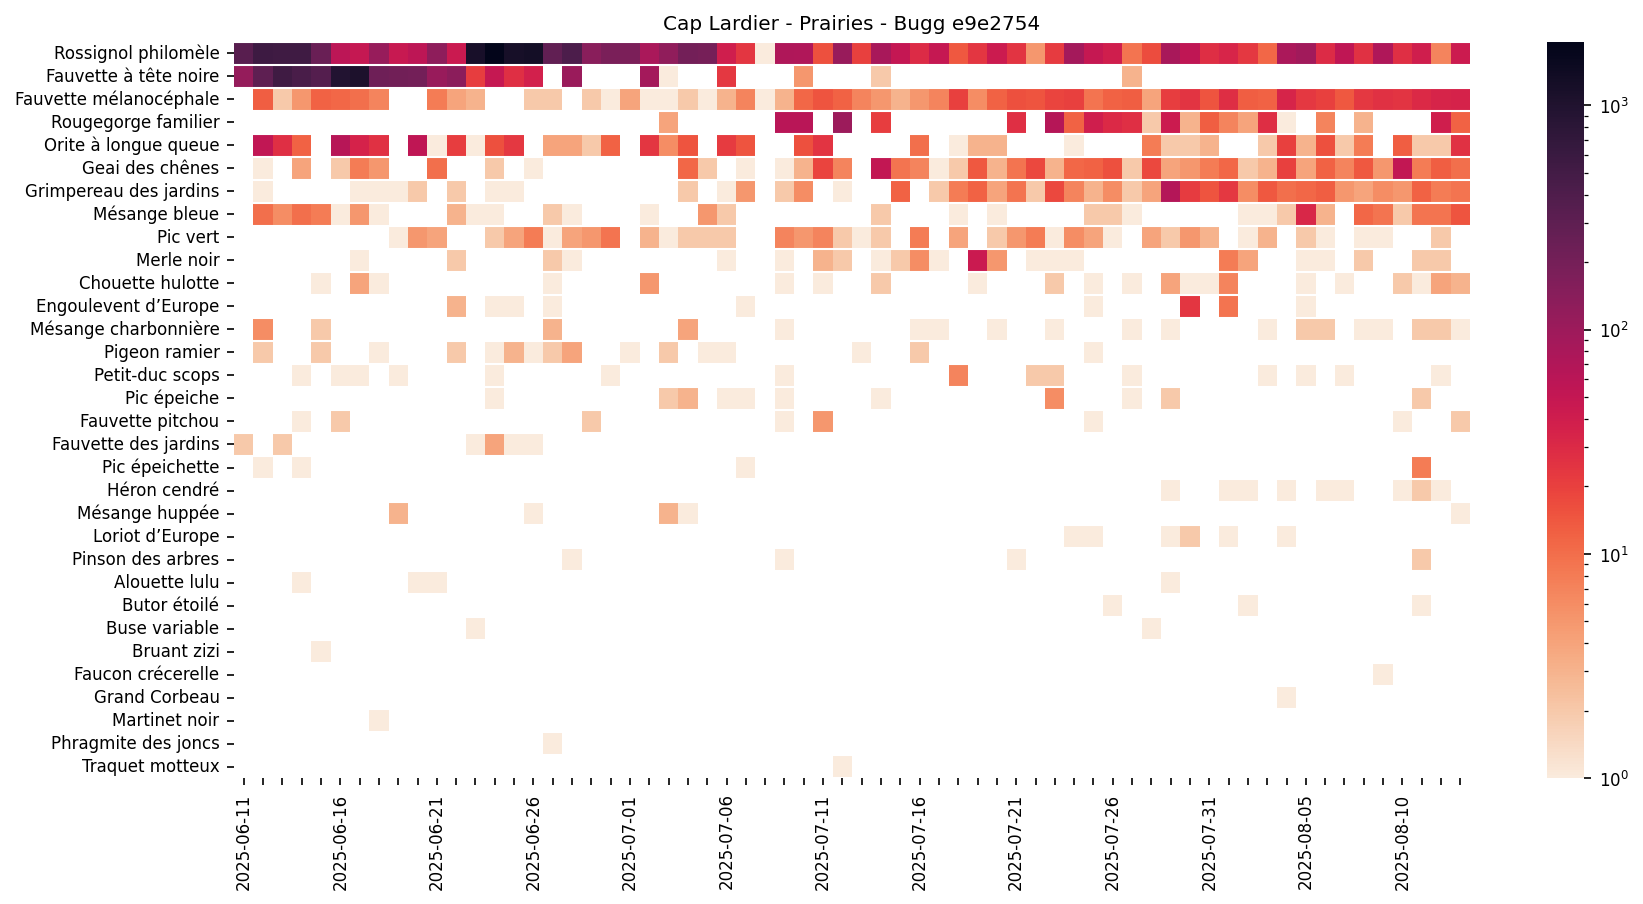

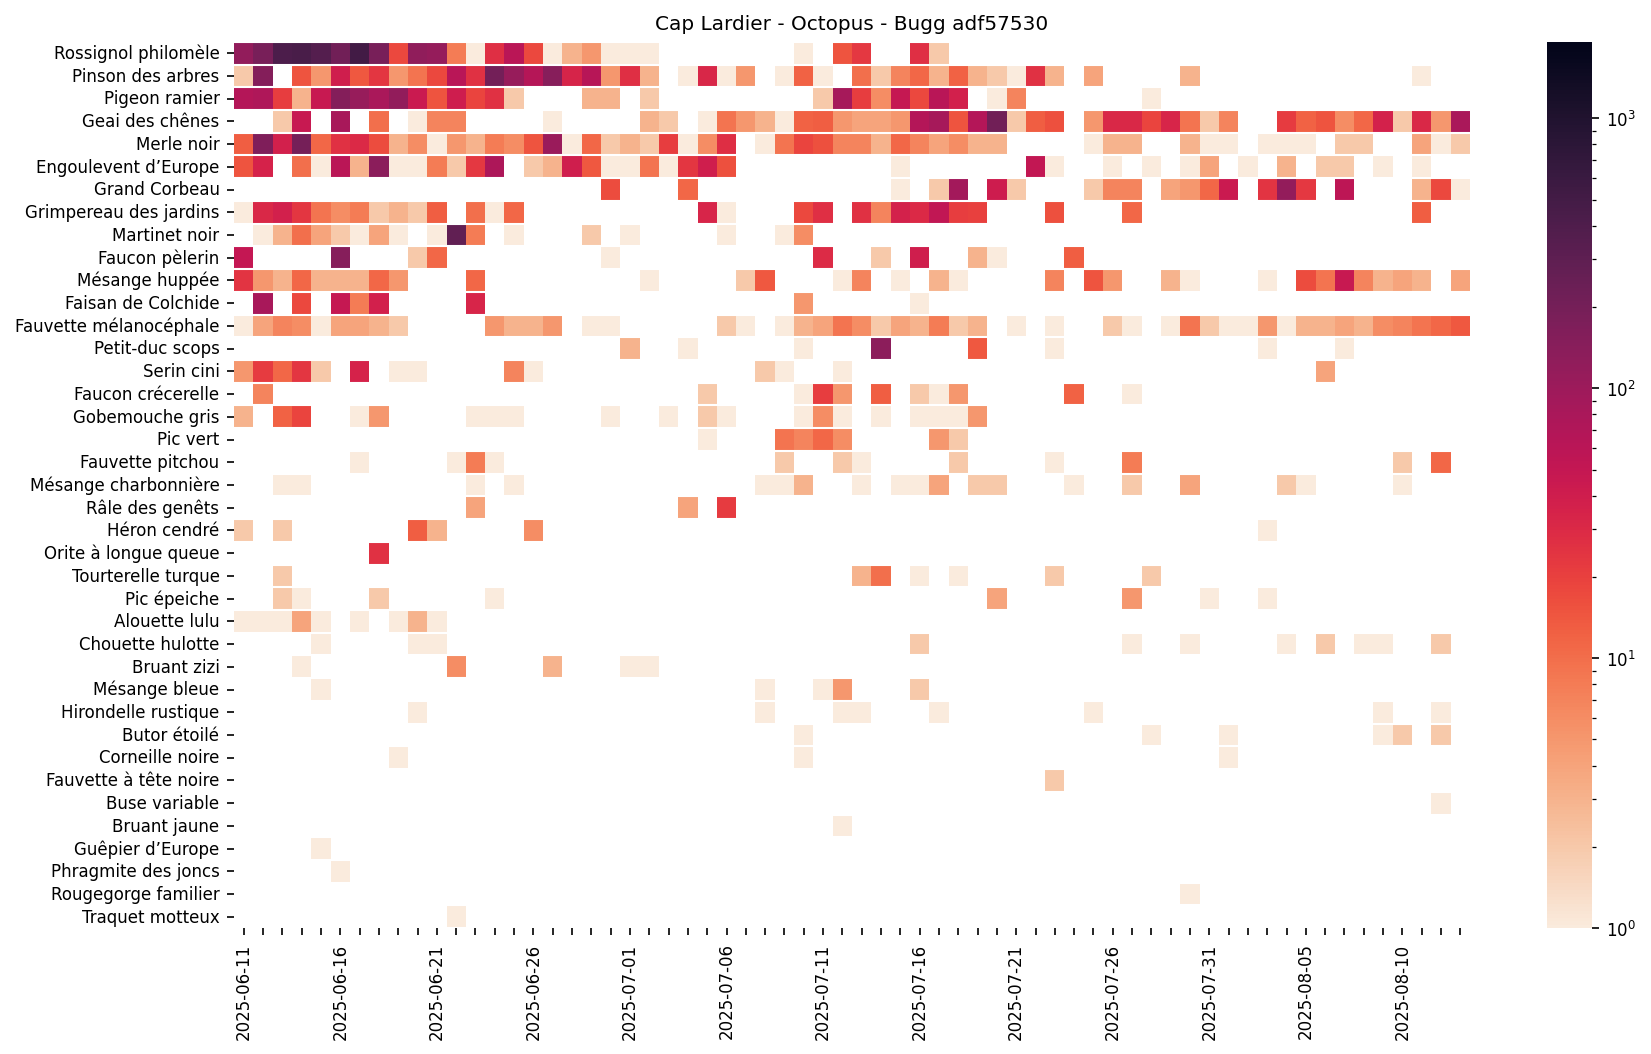

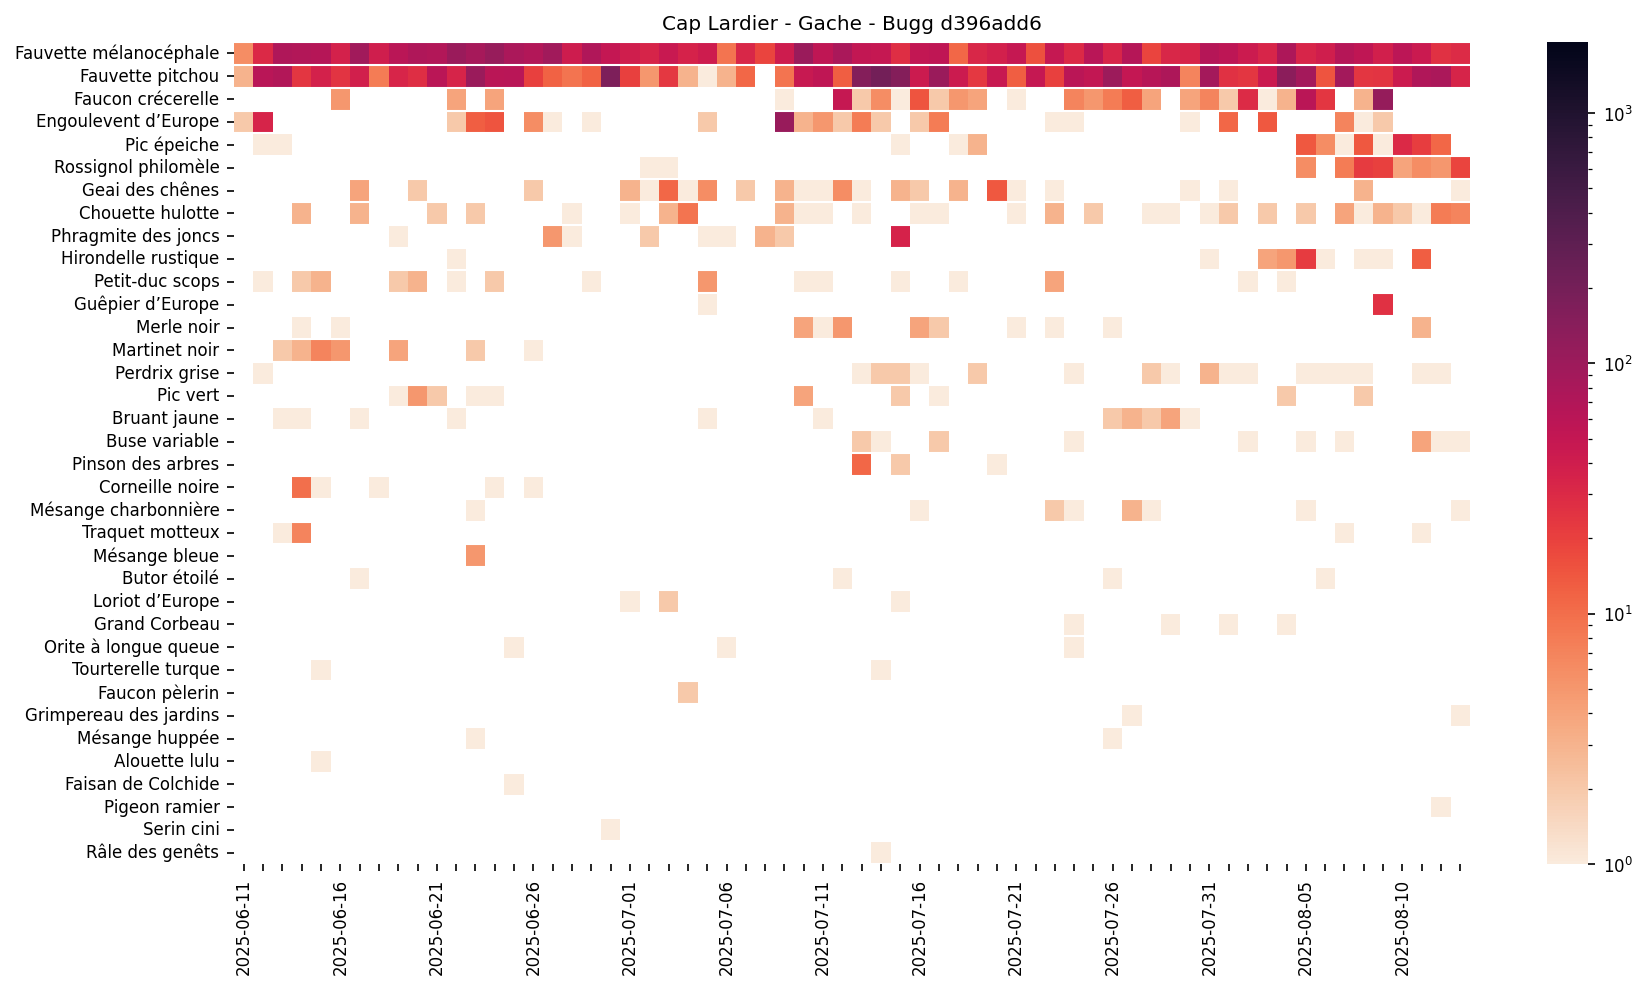

In [32]:

base_df = predictions_df.groupby(['date', 'common name']).size().unstack(fill_value=0)
vmax = base_df.to_numpy().max()
cmap = sns.cm.rocket_r


for i, bugg_id in enumerate(bugg_id_list):

    grouped_df  = predictions_df[predictions_df['device_id'] == bugg_id]
    grouped_df = grouped_df.groupby(['date', 'common name']).size().unstack(fill_value=0)
    grouped_df = grouped_df.sort_index() # Sort by date 
    
    #grouped_df = grouped_df.loc[:,grouped_df.sum()>N_occurence_threshold_annual] #keep species with more than N occurence
    grouped_df = grouped_df.loc[:,species_occurence_filter] #keep species with more than N occurence
    species_order = grouped_df.sum().sort_values(ascending=False).index.tolist()
    grouped_df = grouped_df[species_order]

    grouped_df = grouped_df.reindex(analyzed_date_range, fill_value=0)

    n_species = grouped_df.shape[1]

    fig, ax = plt.subplots(figsize=(plot_width, 1.5 + n_species/7))

    sns.heatmap(grouped_df.T,cmap = cmap, cbar_kws={"shrink": 1}, linewidth=0, norm=(LogNorm(vmin=1, vmax=vmax)))

    for j in range(grouped_df.T[grouped_df.sum(axis=0) != 0].shape[1]+1):
        ax.axhline(j, color='white', lw=1)

    #sns.heatmap(grouped_df.T, cmap = cmap, cbar_kws={"shrink": 0.5})
    ax.set_title(f"{cluster_name} - {site_list[i]} - Bugg {bugg_id}")
    ax.set_ylabel("")
    ax.set_xlabel("")

    xticks = ax.xaxis.get_major_ticks()
    for j,tick in enumerate(xticks):
        if j%date_tick != 0:
            tick.label1.set_visible(False)

    plt.tight_layout()






In [33]:
import warnings
warnings.filterwarnings('ignore')
#os.system(f'jupyter nbconvert --execute --to pdf --no-input  --template custom_template.tplx --output "tabmon_report_{cluster_name}.pdf" "TABMON report.ipynb"')
import subprocess

subprocess.run(
    [
        "jupyter", "nbconvert",
        "--to", "pdf",
        "--no-input",
        "--template-file=custom_template.tex.j2",
        f"--output=Rapport_TABMON_{cluster_name}.pdf",
        "Rapport TABMON.ipynb" 
    ],
    stdout=subprocess.DEVNULL,  # suppress standard output
    stderr=subprocess.DEVNULL   # suppress error messages
);

#subprocess.run(
#    [
#        "pdfcrop",
#        "--margins", "25 30 25 30",
#        f"tabmon_report_{cluster_name}.pdf",
#        f"tabmon_report_{cluster_name}.pdf"
#    ],
#    stdout=subprocess.DEVNULL,  # hide normal output
#    stderr=subprocess.DEVNULL   # hide warnings/errors
#);

In [34]:
#os.system(f'jupyter nbconvert --to latex --template-file custom_template.tex.j2 "TABMON report.ipynb"')
#os.system(f'jupyter nbconvert --to pdf --no-input  --template-file custom_template.tex.j2 --output "tabmon_report_{cluster_name}.pdf" "TABMON report.ipynb"')
#os.system(f'jupyter nbconvert --to pdf --template-file custom_template.tex.j2 --output "Rapport_TAB%ON_{cluster_name}.pdf" "Rapport TABMON.ipynb"')pri